# 说明
- 是论文 "2020-A CNN-LSTM-Based Model to Forecast Stock Prices" 和 "2021-A CNN-BiLSTM-AM method for stock price prediction" 的不完整实现

- 对应的知乎解释文章：https://zhuanlan.zhihu.com/p/22539085944
- Author： Bryce Wang


*论文互助小组*
AI缝合论文发表互助小组(非盈利，纯学术)，欢迎大部分时间都在自我摸索的学术孤儿加入：brycewang2018@gmail.com/brycew6m@stanford.edu。

# 数据准备

In [14]:
import yfinance as yf
import polars as pl
import asyncio
import aiohttp
import pickle
import numpy as np
import random
import joblib
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from tqdm import tqdm
import nest_asyncio
import pyarrow as pa

nest_asyncio.apply()  # Allow running async code in Jupyter Notebook

tickers = [
    'TSLA', 'AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'AMD',
    'SPY', 'V', 'DIS', 'HD', 'UNH', 'MCD', 'BA', 'XIU.TO'
]

# Standardize column format
STANDARD_COLUMNS = ["Date", "Open", "High", "Low", "Close", "Volume", "Ticker"]

async def fetch_stock_data(ticker):
    try:
        t = yf.Ticker(ticker)
        df = t.history(period="10y", interval="1d")

        if df.empty:
            print(f"Warning: {ticker} has no data!")
            return None

        df.reset_index(inplace=True)
        df["Ticker"] = ticker

        # Retain only standard columns
        df = df[["Date", "Open", "High", "Low", "Close", "Volume", "Ticker"]]

        # Ensure consistent data types
        df["Date"] = df["Date"].astype(str)  # Prevent polars from automatically converting to date type
        df.fillna(0, inplace=True)  # Handle NaN values

        return pl.from_arrow(pa.Table.from_pandas(df))
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")
        return None

async def fetch_all_stocks():
    tasks = [fetch_stock_data(ticker) for ticker in tickers]
    results = await asyncio.gather(*tasks)
    return [df for df in results if df is not None]

# Run the download task
stock_data = asyncio.run(fetch_all_stocks())

# Ensure all DataFrames have the same columns
for i, df in enumerate(stock_data):
    missing_cols = set(STANDARD_COLUMNS) - set(df.columns)
    for col in missing_cols:
        df = df.with_columns(pl.Series(col, [0] * len(df)))  # Fill missing columns
    stock_data[i] = df.select(STANDARD_COLUMNS)  # Standardize column order

# Merge all data
df_all = pl.concat(stock_data)
print(df_all.shape)

# Remove unnecessary columns
df_all = df_all.drop(["Date"])  # Keep only numerical data

# Standardize data
#scaler = StandardScaler()
df_all_numeric = df_all.select(["Open", "High", "Low", "Close", "Volume"]).to_numpy()
#df_all_scaled = scaler.fit_transform(df_all_numeric)
df_all_scaled = df_all_numeric

# Reconstruct DataFrame while keeping numeric columns
df_all = df_all.with_columns(
    pl.DataFrame(df_all_scaled, schema=["Open", "High", "Low", "Close", "Volume"])
)

print("Data download and preprocessing completed!")


df_all = pd.DataFrame(df_all)
df_all.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
df_all.head()
df_all.to_csv('data/df_all.csv', index=False)

df_all.head()

(37720, 7)
Data download and preprocessing completed!


,Open,High,Low,Close,Volume,Ticker
0,13.713333,13.713333,13.433333,13.623333,59694000.0,TSLA
1,13.611333,13.744667,13.506667,13.630667,40704000.0,TSLA
2,13.666667,14.162667,13.583333,14.114,77311500.0,TSLA
3,14.052,14.506667,13.987333,14.474,89731500.0,TSLA
4,14.377333,14.546667,13.755333,13.822667,127497000.0,TSLA


# LSTM: Tesla

Epoch 1/50


/Users/brycewang/Documents/GitHub/cnn-lstm-stock/cl_stock_tf/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0020
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3106e-04 - val_loss: 0.0018
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8304e-04 - val_loss: 0.0016
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5590e-04 - val_loss: 0.0023
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1922e-04 - val_loss: 0.0014
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1433e-04 - val_loss: 0.0014
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4940e-04 - val_loss: 0.0014
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9612e-04 - val_loss: 0.0022
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2401e-04 - val_loss: 0.0012
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9130e-04 - val_loss: 0.0010
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8159e-04 - val_loss: 9.8953e-04
Epoch 12/50
110/110

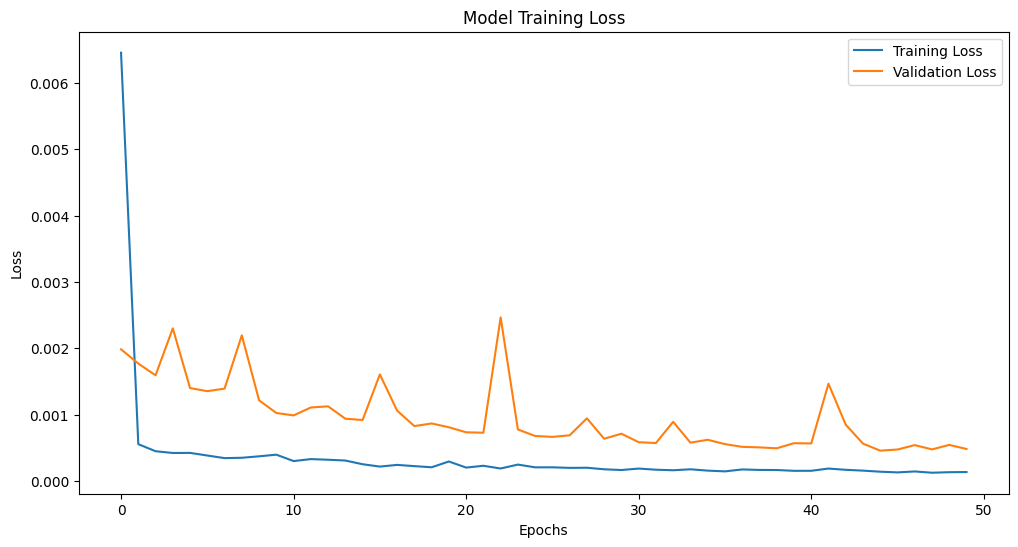

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7577e-04
Test Loss (MSE): 0.0005555060924962163
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


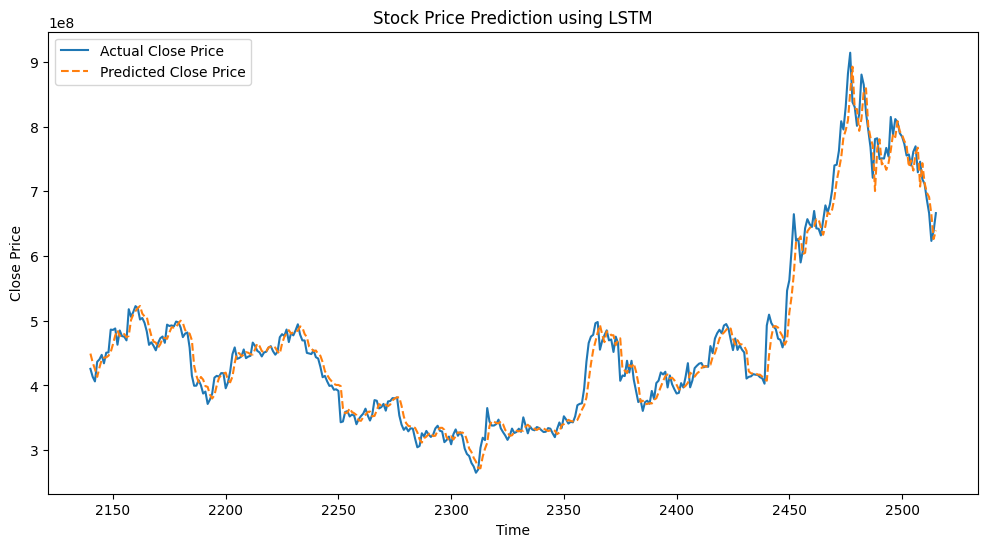

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 读取数据
file_path = "data/df_tesla.csv"  # 替换为你的文件路径
df = pd.read_csv(file_path)

# 归一化数据
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 定义窗口大小
window_size = 10

# 创建特征和目标数据
features = []
targets = []

for i in range(len(df_scaled) - window_size):
    features.append(df_scaled.iloc[i:i+window_size].values)
    targets.append(df_scaled.iloc[i+window_size]['Close'])

# 转换为 NumPy 数组
X = np.array(features)
y = np.array(targets)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 创建 LSTM 模型
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size, X.shape[2])),
    LSTM(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型并记录训练过程
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# 训练过程可视化
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 评估模型
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# 预测
y_pred = model.predict(X_test)


# 反归一化实际的收盘价 (Close)
df_temp = df[['Close']][-len(y_test):].copy()
df_temp['Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, -1]

# 反归一化预测的收盘价 (Predicted_Close)
df_temp['Predicted_Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), df.shape[1] - 1)), y_pred.reshape(-1, 1)], axis=1)
)[:, -1]

# 显示预测结果
plt.figure(figsize=(12, 6))
plt.plot(df_temp.index, df_temp['Close'], label="Actual Close Price")
plt.plot(df_temp.index, df_temp['Predicted_Close'], label="Predicted Close Price", linestyle="dashed")
plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

# CNN+BiLSTM: Tesla

Epoch 1/50


/Users/brycewang/Documents/GitHub/cnn-lstm-stock/cl_stock_tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0230 - val_loss: 0.0019
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4604e-04 - val_loss: 0.0018
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1285e-04 - val_loss: 0.0016
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8211e-04 - val_loss: 0.0020
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7989e-04 - val_loss: 0.0017
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1981e-04 - val_loss: 0.0022
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2598e-04 - val_loss: 0.0015
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3743e-04 - val_loss: 0.0016
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7078e-04 - val_loss: 0.0016
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4662e-04 - val_loss: 0.0020
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9844e-04 - val_loss: 0.0018
Epoch 12/50
110/110 ━━━

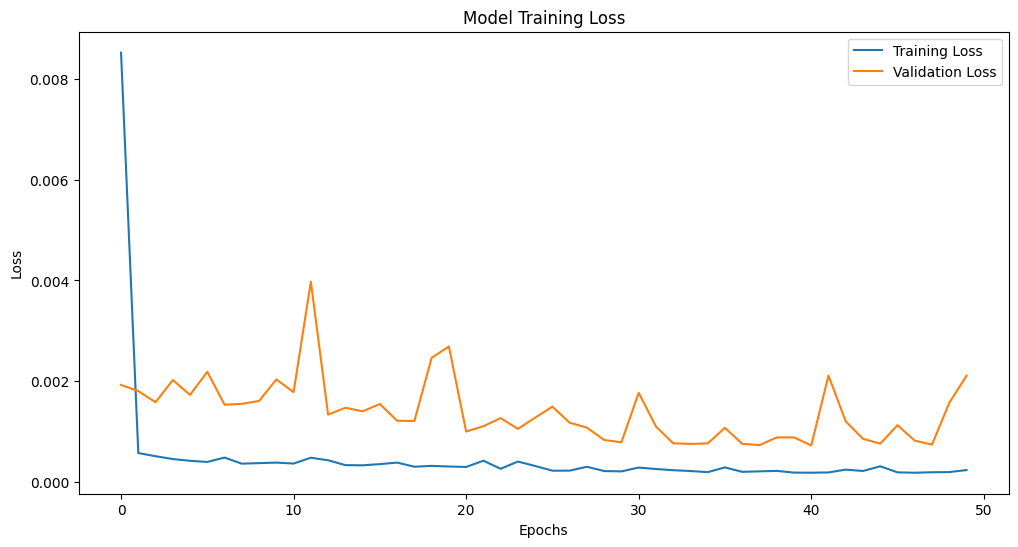

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Test Loss (MSE): 0.001810046611353755
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


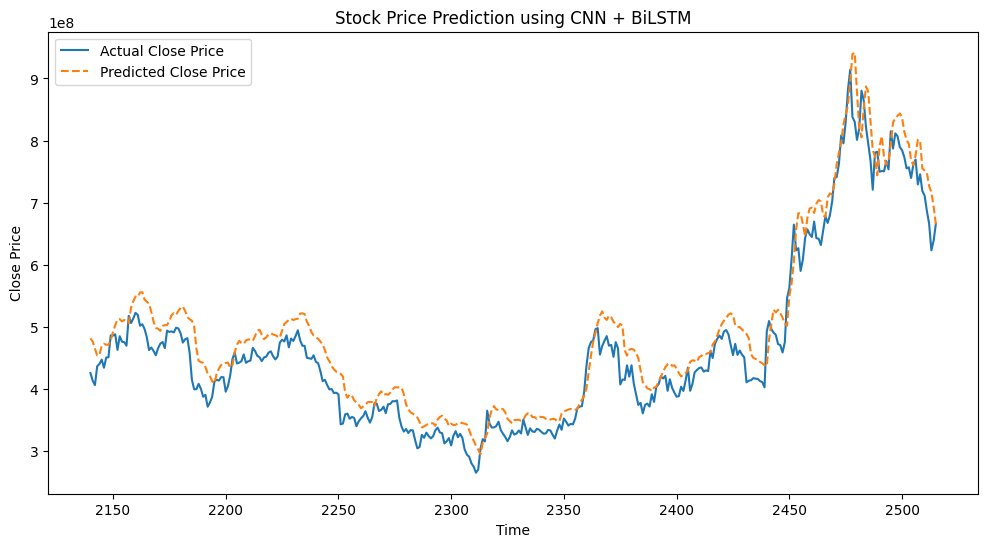

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 读取数据
file_path = "data/df_tesla.csv"  # 替换为你的文件路径
df = pd.read_csv(file_path)

# 归一化数据
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 定义窗口大小
window_size = 10

# 创建特征和目标数据
features = []
targets = []

for i in range(len(df_scaled) - window_size):
    features.append(df_scaled.iloc[i:i+window_size].values)
    targets.append(df_scaled.iloc[i+window_size]['Close'])

# 转换为 NumPy 数组
X = np.array(features)
y = np.array(targets)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 创建 CNN + BiLSTM 模型
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(50, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(50, activation='relu')),
    Dense(25, activation='relu'),
    Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型并记录训练过程
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# 训练过程可视化
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 评估模型
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# 预测
y_pred = model.predict(X_test)

# 反归一化实际的收盘价 (Close)
df_temp = df[['Close']][-len(y_test):].copy()
df_temp['Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, -1]

# 反归一化预测的收盘价 (Predicted_Close)
df_temp['Predicted_Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), df.shape[1] - 1)), y_pred.reshape(-1, 1)], axis=1)
)[:, -1]

# 显示预测结果
plt.figure(figsize=(12, 6))
plt.plot(df_temp.index, df_temp['Close'], label="Actual Close Price")
plt.plot(df_temp.index, df_temp['Predicted_Close'], label="Predicted Close Price", linestyle="dashed")
plt.legend()
plt.title("Stock Price Prediction using CNN + BiLSTM")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

# CNN+LSTM+AM: Tesla    

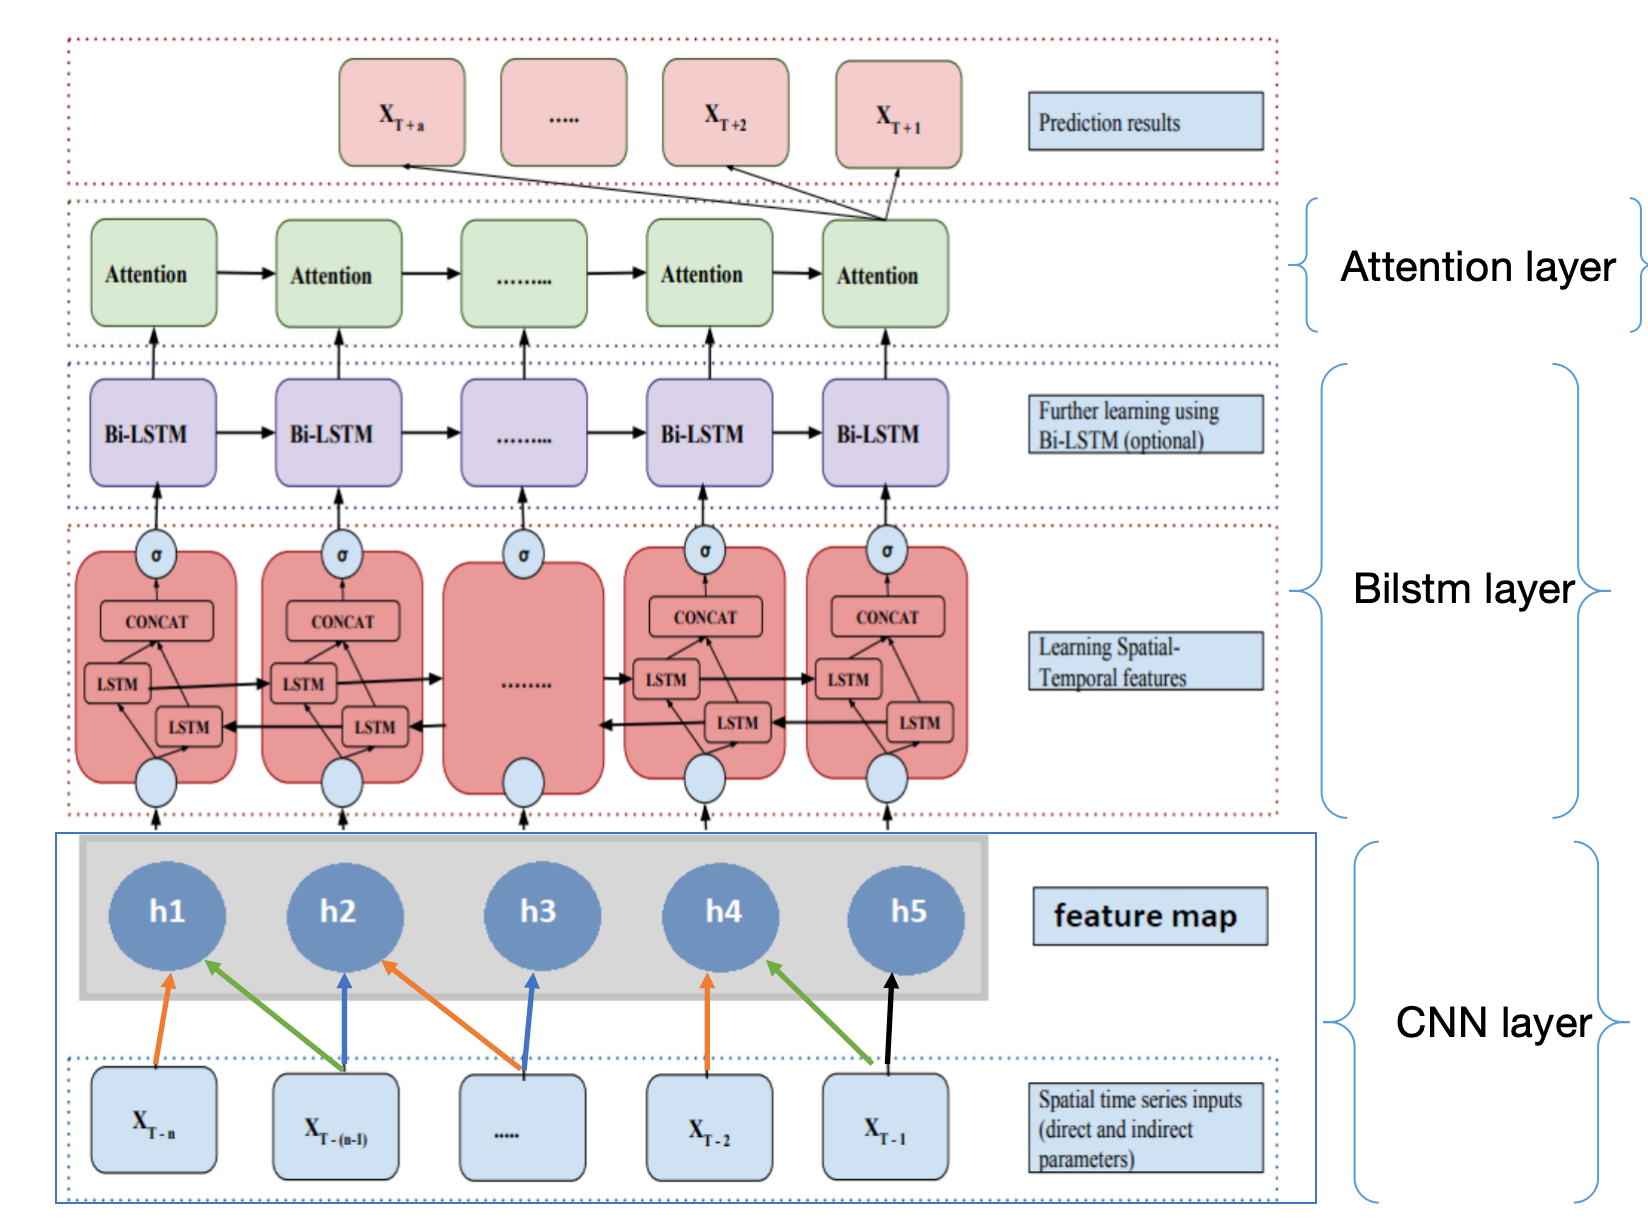

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0269 - val_loss: 0.0018
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5119e-04 - val_loss: 0.0020
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0812e-04 - val_loss: 0.0015
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0717e-04 - val_loss: 0.0015
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1242e-04 - val_loss: 0.0020
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1503e-04 - val_loss: 0.0058
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6048e-04 - val_loss: 0.0015
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7759e-04 - val_loss: 0.0015
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7560e-04 - val_loss: 0.0020
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0867e-04 - val_loss: 0.0026
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2164e-04 - val_loss: 0.0013
Epoch 12/50


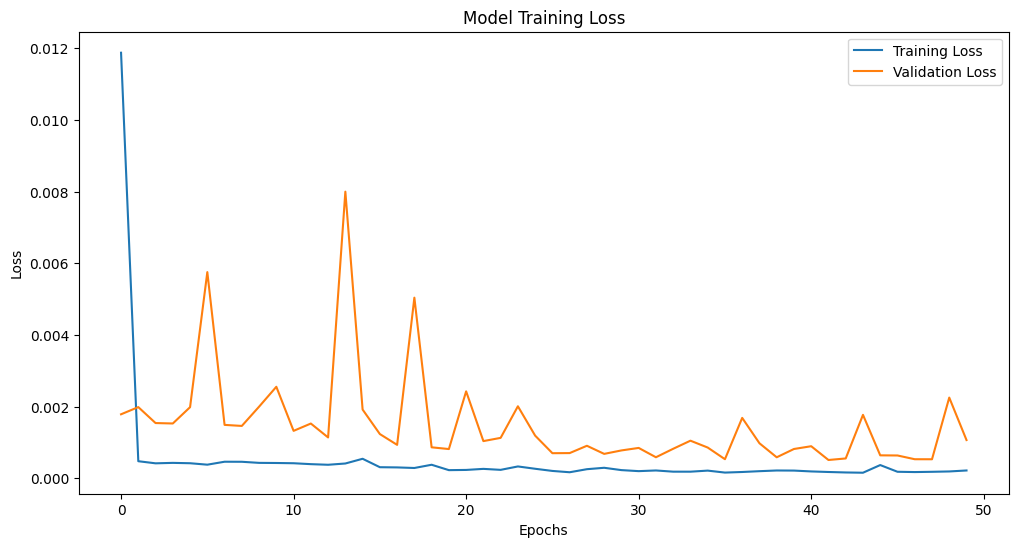

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5623e-04
Test Loss (MSE): 0.0009905718034133315
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


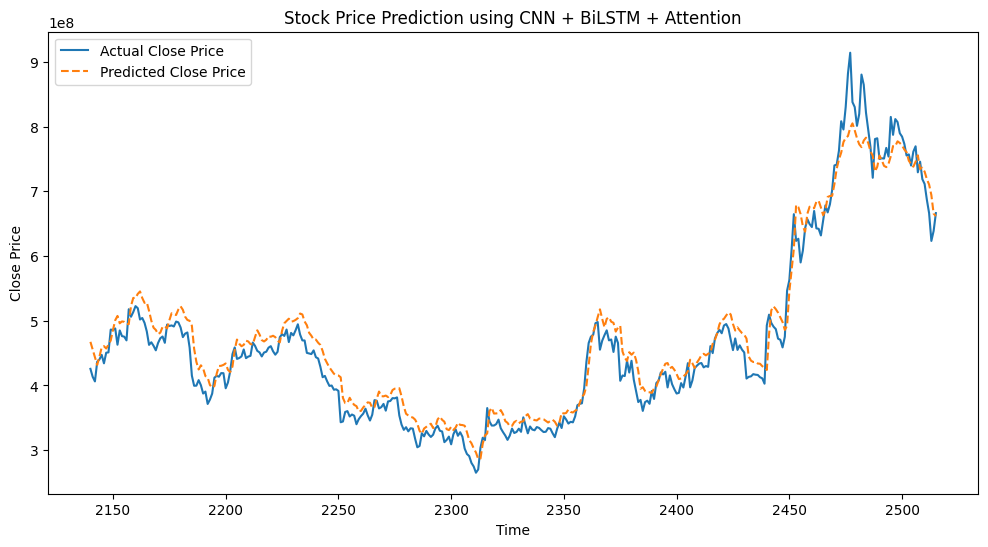

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Attention, Input, Multiply, Permute, Lambda
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 读取数据
file_path = "data/df_tesla.csv"  # 替换为你的文件路径
df = pd.read_csv(file_path)

# 归一化数据
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 定义窗口大小
window_size = 10

# 创建特征和目标数据
features = []
targets = []

for i in range(len(df_scaled) - window_size):
    features.append(df_scaled.iloc[i:i+window_size].values)
    targets.append(df_scaled.iloc[i+window_size]['Close'])

# 转换为 NumPy 数组
X = np.array(features)
y = np.array(targets)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 定义注意力机制
def attention_block(inputs):
    score = Dense(1, activation='tanh')(inputs)
    attention_weights = Lambda(lambda x: tf.nn.softmax(x, axis=1))(score)
    context_vector = Multiply()([inputs, attention_weights])
    return context_vector

# 创建 CNN + BiLSTM + 注意力模型
inputs = Input(shape=(window_size, X.shape[2]))
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(x)
x = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(x)
x = attention_block(x)
x = Bidirectional(LSTM(50, activation='relu'))(x)
x = Dense(25, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型并记录训练过程
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# 训练过程可视化
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 评估模型
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# 预测
y_pred = model.predict(X_test)

# 反归一化实际的收盘价 (Close)
df_temp = df[['Close']][-len(y_test):].copy()
df_temp['Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, -1]

# 反归一化预测的收盘价 (Predicted_Close)
df_temp['Predicted_Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), df.shape[1] - 1)), y_pred.reshape(-1, 1)], axis=1)
)[:, -1]

# 显示预测结果
plt.figure(figsize=(12, 6))
plt.plot(df_temp.index, df_temp['Close'], label="Actual Close Price")
plt.plot(df_temp.index, df_temp['Predicted_Close'], label="Predicted Close Price", linestyle="dashed")
plt.legend()
plt.title("Stock Price Prediction using CNN + BiLSTM + Attention")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()


## 使用 keras 自带的 attention 模块

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0232 - val_loss: 0.0028
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3551e-04 - val_loss: 0.0017
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5387e-04 - val_loss: 0.0017
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3580e-04 - val_loss: 0.0020
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4107e-04 - val_loss: 0.0025
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9277e-04 - val_loss: 0.0018
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5111e-04 - val_loss: 0.0019
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5735e-04 - val_loss: 0.0017
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4608e-04 - val_loss: 0.0015
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6543e-04 - val_loss: 0.0016
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2459e-04 - val_loss: 0.0013
Epoch 12/50


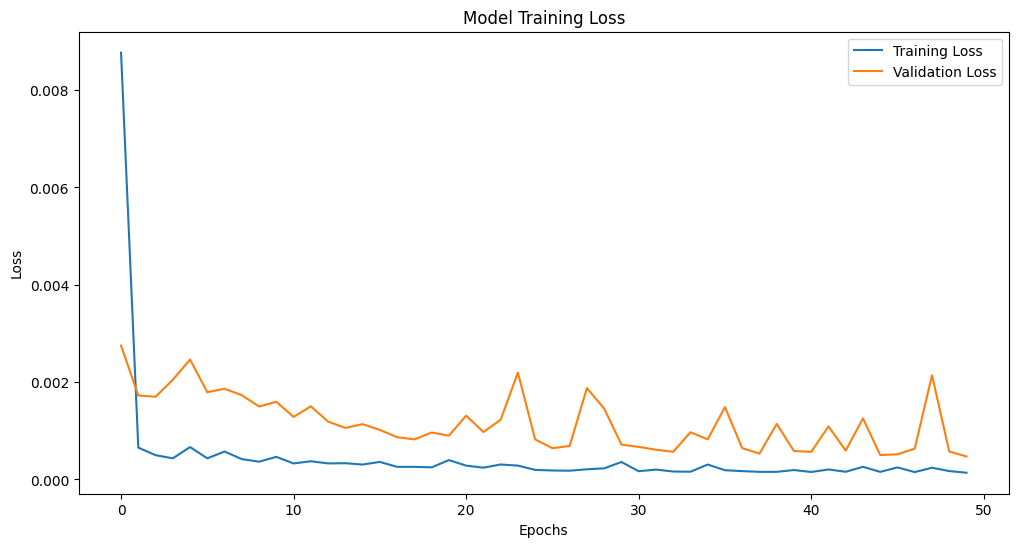

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0228e-04
Test Loss (MSE): 0.0007527942070737481
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


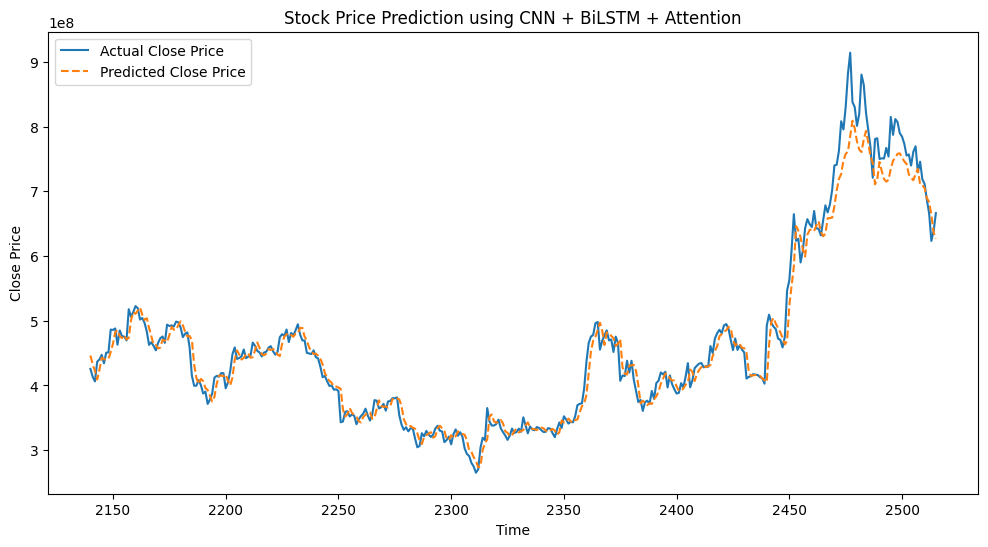

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Attention, Input, Multiply
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 读取数据
file_path = "data/df_tesla.csv"  # 替换为你的文件路径
df = pd.read_csv(file_path)

# 归一化数据
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 定义窗口大小
window_size = 10

# 创建特征和目标数据
features = []
targets = []

for i in range(len(df_scaled) - window_size):
    features.append(df_scaled.iloc[i:i+window_size].values)
    targets.append(df_scaled.iloc[i+window_size]['Close'])

# 转换为 NumPy 数组
X = np.array(features)
y = np.array(targets)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 使用 Keras 自带的 Attention 机制
def attention_block(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# 创建 CNN + BiLSTM + 注意力模型
inputs = Input(shape=(window_size, X.shape[2]))
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(x)
x = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(x)
x = attention_block(x)
x = Bidirectional(LSTM(50, activation='relu'))(x)
x = Dense(25, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型并记录训练过程
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# 训练过程可视化
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 评估模型
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# 预测
y_pred = model.predict(X_test)

# 反归一化实际的收盘价 (Close)
df_temp = df[['Close']][-len(y_test):].copy()
df_temp['Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), df.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, -1]

# 反归一化预测的收盘价 (Predicted_Close)
df_temp['Predicted_Close'] = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), df.shape[1] - 1)), y_pred.reshape(-1, 1)], axis=1)
)[:, -1]

# 显示预测结果
plt.figure(figsize=(12, 6))
plt.plot(df_temp.index, df_temp['Close'], label="Actual Close Price")
plt.plot(df_temp.index, df_temp['Predicted_Close'], label="Predicted Close Price", linestyle="dashed")
plt.legend()
plt.title("Stock Price Prediction using CNN + BiLSTM + Attention")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

In [ ]:
# END 